In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
from scipy.optimize._numdiff import approx_derivative
from scipy.integrate import solve_ivp
from scipy.optimize import OptimizeResult

from throttle_function import throttle_tanh
from dynamics import LowThrustTwoBody
from units import *
from state import Index as I

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
MU = 132712440018  # km^3/s^2
g0 = 9.8065e-3  # km/s^2
m0 = 4000  # kg
Tmax = 0.32e-3  # kN
Isp = 3000  # s

rv0 = np.array([
    -3637871.081, 147099798.784, -2261.441,
    -30.265097, -0.8486854, 0.0000505
])  # [km] and [km/s]

# t0 = 56284 * 86400  # MJD * sec
t0 = 0  # MJD * sec
dt = 3534 * 86400 / TU
tn = t0 + dt

# normalize
rv0[:3] /= DU
rv0[3:] /= (DU / TU)
m0 /= MaU
MU /= (DU ** 3 / TU ** 2)
Tmax /= (MaU * DU / TU ** 2)
Isp /= TU
g0 /= (DU / TU ** 2)

np.random.seed(0)
costate = np.random.rand(7) * 0.1
Phi0 = np.eye(14)
X0 = np.r_[rv0, m0, costate, Phi0.ravel()]
print(X0.shape)

(210,)


In [3]:
dyn = LowThrustTwoBody(
    mu=MU, thrust_max=Tmax, Isp=Isp, g0=g0, rho=1 
)
dyn.variation = True
print(dyn.time_derivative(t0, X0).shape)

(210,)


In [4]:
sol = solve_ivp(
    dyn.time_derivative, (t0, tn), X0,
    method='DOP853', rtol=1e-9, atol=1e-9,
    t_eval=np.linspace(t0, tn, 10000)
)


In [5]:
def shooting(rv_f, lmf, rv_t):
    drv = rv_f - rv_t
    return np.array([*drv, lmf])

In [6]:
# rv = sol.y[I.rv]
# m = sol.y[I.m].ravel()
# lr = sol.y[I.lr]
# lv = sol.y[I.lv]
# lm = sol.y[I.lm].ravel()

In [48]:
rv_t = np.array([
    -1.26725023, 3.09190622, 0.40526029, 
    -0.3132259 , -0.19178898, 0.0687792
])

def evaluate_sol(costate0, variation=False, dense=False):
    if variation:
        x0 = np.r_[rv0, m0, costate0, Phi0.ravel()]
    else:
        x0 = np.r_[rv0, m0, costate0]
    dyn.variation = variation
    sol = solve_ivp(
        dyn.time_derivative, (t0, tn), x0,
        method='DOP853', rtol=1e-9, atol=1e-9,
        # method='RK45',
        t_eval=np.linspace(t0, tn, 10000) if dense else None
    )
    return sol

def objective(costate0):
    sol = evaluate_sol(costate0)
    rv = sol.y[I.rv]
    lm = sol.y[I.lm].ravel()
    obj_val = shooting(rv[:, -1], lm[-1], rv_t)
    # print(obj_val)
    return obj_val

def dobj_dcostate0(costate0):
    sol = evaluate_sol(costate, variation=True)
    rv = sol.y[I.rv]
    lm = sol.y[I.lm].ravel()
    obj_val = shooting(rv[:, -1], lm[-1], rv_t)
    dXdX0 = sol.y[14:].reshape(14, 14, -1)
    drf_dl0 = dXdX0[..., -1][I.i(I.r, I.l)]
    dvf_dl0 = dXdX0[..., -1][I.i(I.v, I.l)]
    dlmf_dl0 = dXdX0[..., -1][I.i(I.lm, I.l)].ravel()
    partial = np.vstack((drf_dl0, dvf_dl0, dlmf_dl0))
    return partial, obj_val

def obj_scalar(costate0):
    obj = objective(costate0)
    return 0.5 * obj @ obj

def jac_scalar(costate0):
    partial, obj = dobj_dcostate0(costate0)
    return partial.T @ obj

def evaluate_auxiliary(sol):
    # evaluate the auxiliary variables from integration results
    n = sol.t.shape[0]
    rv = sol.y[I.rv]
    m = sol.y[I.m].ravel()  # (n, )
    lr = sol.y[I.lr]
    lv = sol.y[I.lv]  # (3, n)
    lm = sol.y[I.lm].ravel()
    dXdX0 = sol.y[14:].reshape(14, 14, -1)

    sf = dyn.c * np.linalg.norm(lv, axis=0) / m + lm - 1
    u_tanh = throttle_tanh(sf, dyn.rho)
    u = 0.5 * (1 + np.sign(sf))
    sol_aux = OptimizeResult(
        t=sol.t, rv=rv, sf=sf, u_tanh=u_tanh, u=u,
        dXdX0=dXdX0
    )
    return sol_aux

In [9]:
# num_diff = approx_derivative(objective, costate)
# theo_diff = dobj_dcostate0(costate)
# print(theo_diff[0])
# print()
# print(num_diff - theo_diff[0])

In [10]:
%%timeit
objective(costate)
# DOP853
# 43.1 ms ± 70 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
# RK45
# 8.78 ms ± 63.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

44.3 ms ± 270 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit
dobj_dcostate0(costate)
# DOP853
# 573 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# RK45
# 119 ms ± 913 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

577 ms ± 970 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
dyn.rho = 1e-3
# x0 = np.random.rand(7) * 2 - 1
x0 = msol.x
objective(x0)

array([ 2.97993242e-03,  1.85659005e-03,  3.33392166e-04, -7.08963789e-05,
        5.80587865e-04,  3.46999275e-04, -3.99074571e-04])

In [30]:
%%time
def print_callback(x, convergence):
    x_str = np.array2string(x, separator=', ', formatter={'float': '{:.2e}'.format})
    print(f'x: {x_str}, f(x): {obj_scalar(x):.4e}')

msol = opt.differential_evolution(
    obj_scalar, bounds=[(-1, 1)] * 7,
    # callback=print_callback,
    disp=True,
    workers=-1, updating='deferred', recombination=0.8,
    x0=x0,
)

differential_evolution step 1: f(x)= 6.52993e-06
differential_evolution step 2: f(x)= 6.52993e-06
differential_evolution step 3: f(x)= 6.52993e-06
differential_evolution step 4: f(x)= 6.52993e-06
differential_evolution step 5: f(x)= 6.52993e-06
differential_evolution step 6: f(x)= 6.52993e-06
differential_evolution step 7: f(x)= 6.52993e-06
differential_evolution step 8: f(x)= 6.52993e-06
differential_evolution step 9: f(x)= 6.52993e-06
differential_evolution step 10: f(x)= 6.52993e-06
differential_evolution step 11: f(x)= 6.52993e-06
differential_evolution step 12: f(x)= 6.52993e-06
differential_evolution step 13: f(x)= 6.52993e-06
differential_evolution step 14: f(x)= 6.52993e-06
differential_evolution step 15: f(x)= 6.52993e-06
differential_evolution step 16: f(x)= 6.52993e-06
differential_evolution step 17: f(x)= 6.52993e-06
differential_evolution step 18: f(x)= 6.52993e-06
differential_evolution step 19: f(x)= 6.52993e-06
differential_evolution step 20: f(x)= 6.52993e-06
different

In [31]:
x_best = msol.x
print(x_best)
sval = objective(x_best)
sval[:3] *= DU
sval[3:6] *= (DU / TU)
print(f"drf: {sval[:3]} km")
print(f"dvf: {sval[3:6]} km/s")
print(f"lmf: {sval[6]}")

[ 0.05082767 -0.06502794 -0.10709608 -0.1333521  -0.0485314  -0.26530048
  0.38848511]
drf: [  5.79953613  -3.01280437 -10.80765946] km
dvf: [-9.09657768e-07  1.69905109e-06 -1.16474447e-06] km/s
lmf: 7.164300161616744e-08


In [49]:
sol = evaluate_sol(x_best, variation=True, dense=True)
sol_ax = evaluate_auxiliary(sol)

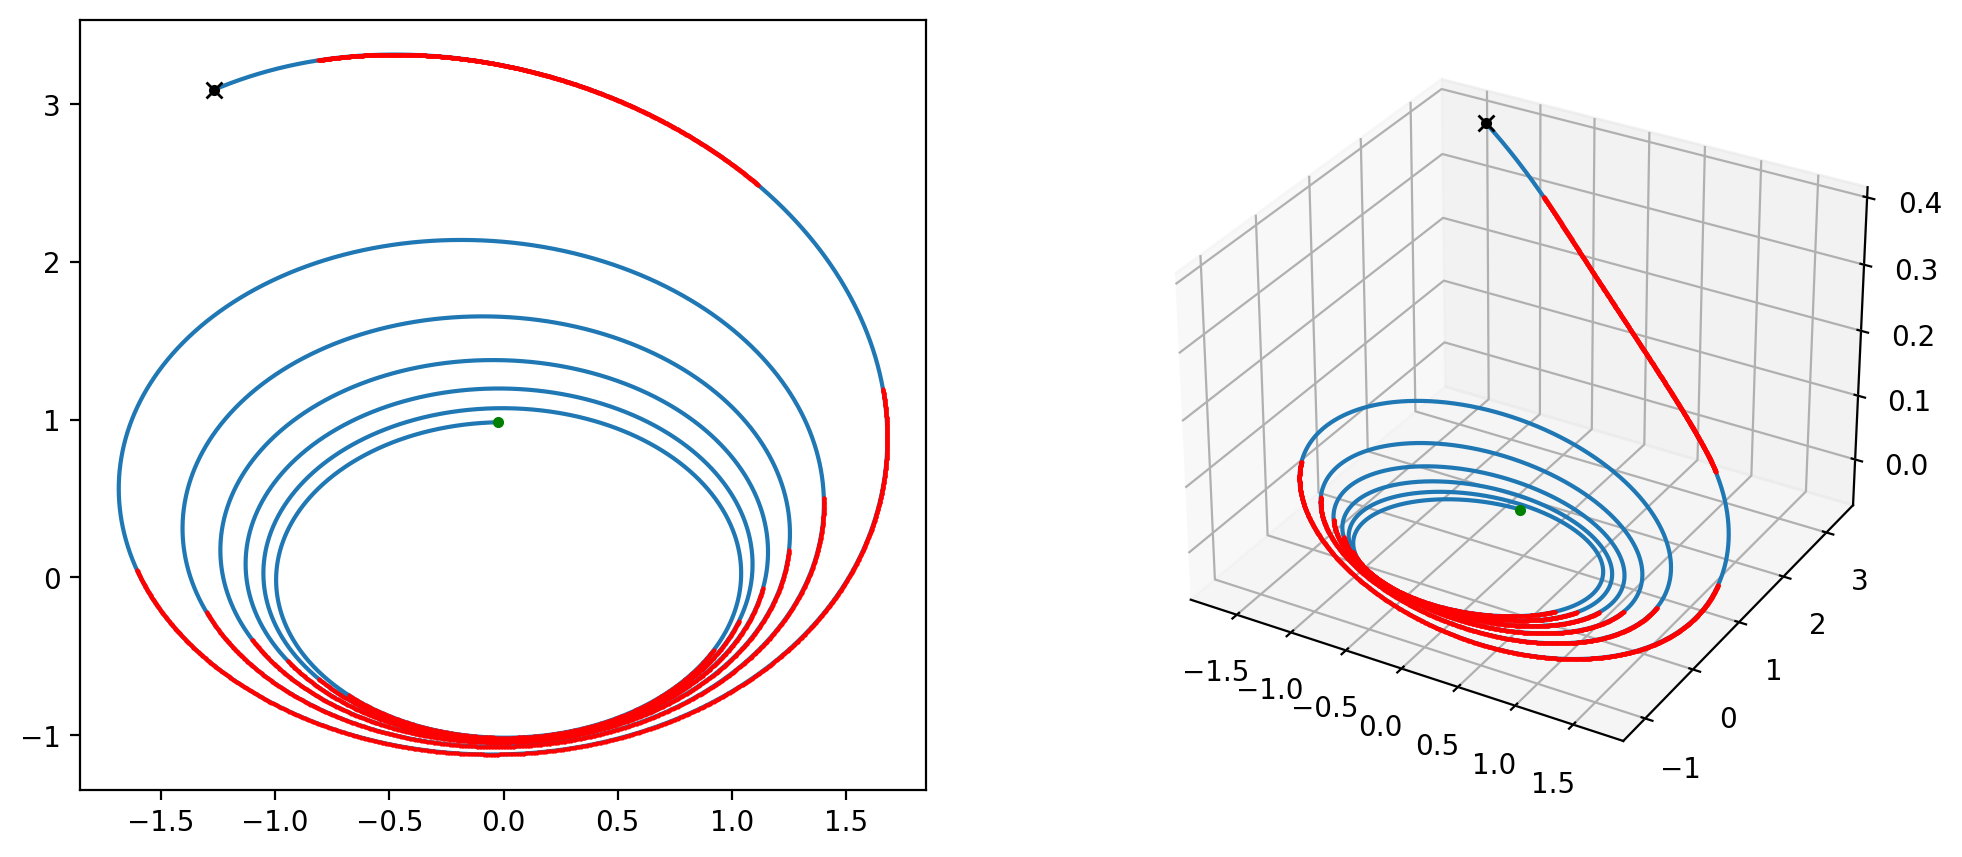

In [50]:
thrust_arc = sol_ax.u_tanh > 0
rv = sol.y[I.rv]
rv_thrust = rv[:, thrust_arc]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(rv[0], rv[1], '-')
ax1.plot(rv_thrust[0], rv_thrust[1], '.', ms=1, c='r')
ax1.plot(rv[0, 0], rv[1, 0], '.', c='g')
ax1.plot(rv[0, -1], rv[1, -1], '.', c='k')
ax1.plot(rv_t[0], rv_t[1], 'x', c='k')
# axi.set_axis('equal')

# plot 3d
ax2.plot(*rv[:3], '-')
ax2.plot(*rv_thrust[:3], '.', ms=1, c='r')
ax2.plot(*rv[:3, 0], '.', c='g')
ax2.plot(*rv[:3, -1], '.', c='k')
ax2.plot(*rv_t[:3], 'x', c='k')
plt.show()

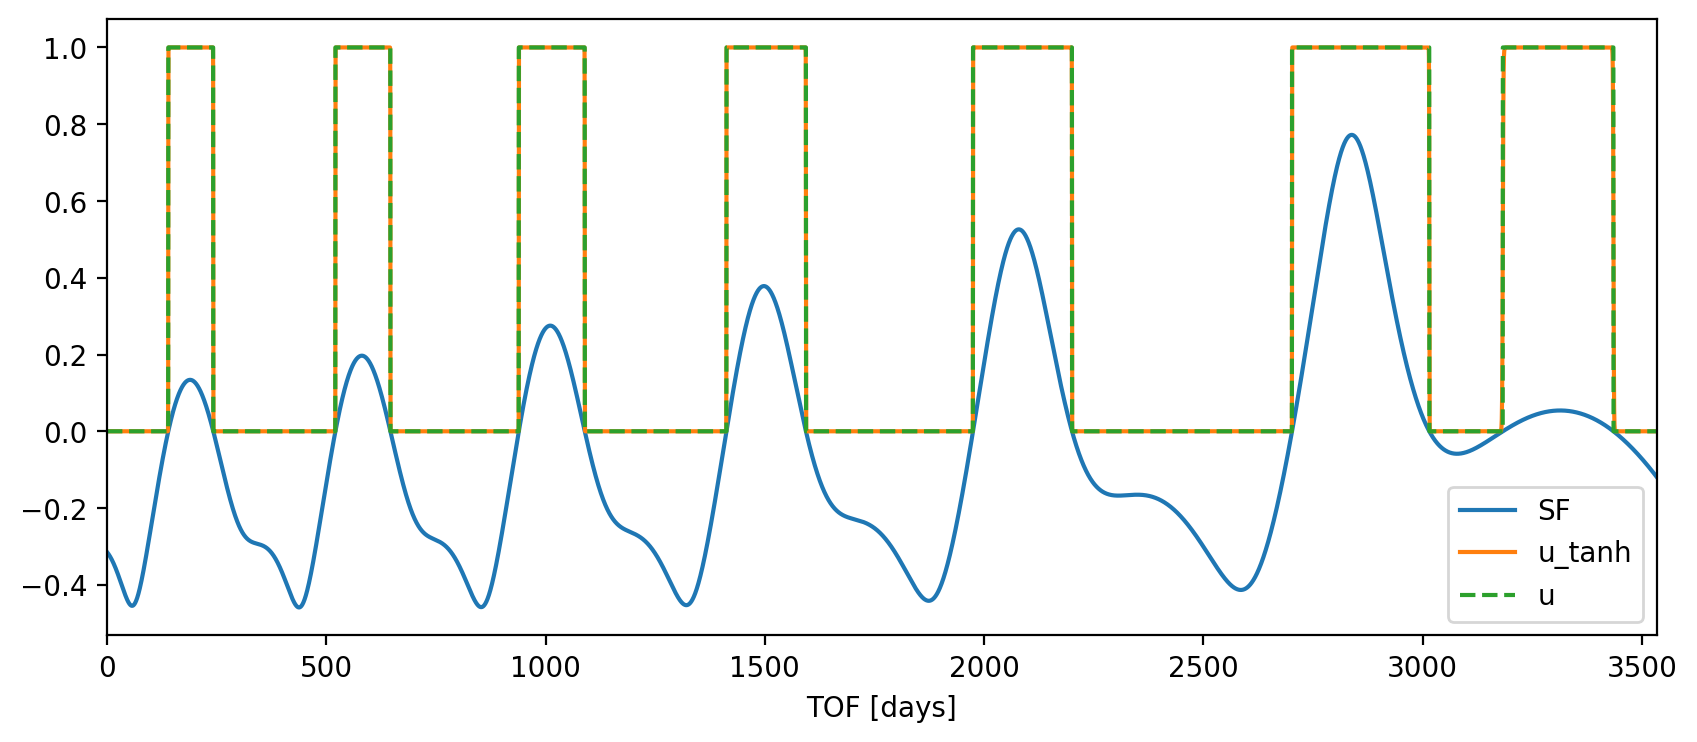

In [51]:
plt.figure(figsize=(10, 4))
t = sol_ax.t * TU / DAY2SEC
plt.plot(t, sol_ax.sf, label='SF')
plt.plot(t, sol_ax.u_tanh, label='u_tanh')
plt.plot(t, sol_ax.u, label='u', ls='--')
plt.xlim(t[0], t[-1])
plt.xlabel('TOF [days]')
plt.legend()

<Axes: >

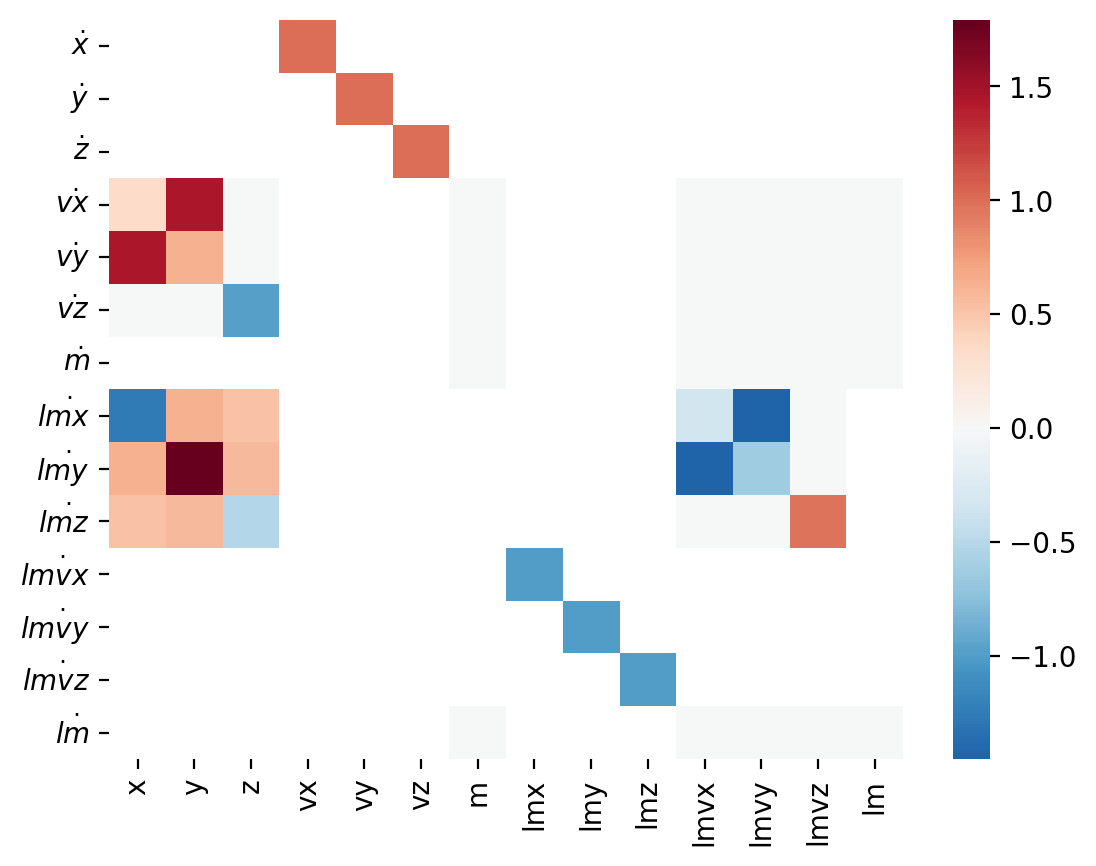

In [55]:
import pandas as pd
import seaborn as sns

tt = sol.t[thrust_arc][0]
Xt = sol.y[:, thrust_arc][:, 0]
dX = dyn.time_derivative(tt, Xt)

names = [
    'x', 'y', 'z', 'vx', 'vy', 'vz', 'm', 
    'lmx', 'lmy', 'lmz', 'lmvx', 'lmvy', 'lmvz', 'lm'
]
names_dot = [r'$\dot{' + name + '}$' for name in names]
df = pd.DataFrame(dyn.dFdX.jac_arr, columns=names, index=names_dot)
df[df == 0] = np.nan
sns.heatmap(df, cmap='RdBu_r', center=0)

initial mass: 4000.0 kg
final mass: 2730.5438019849785 kg


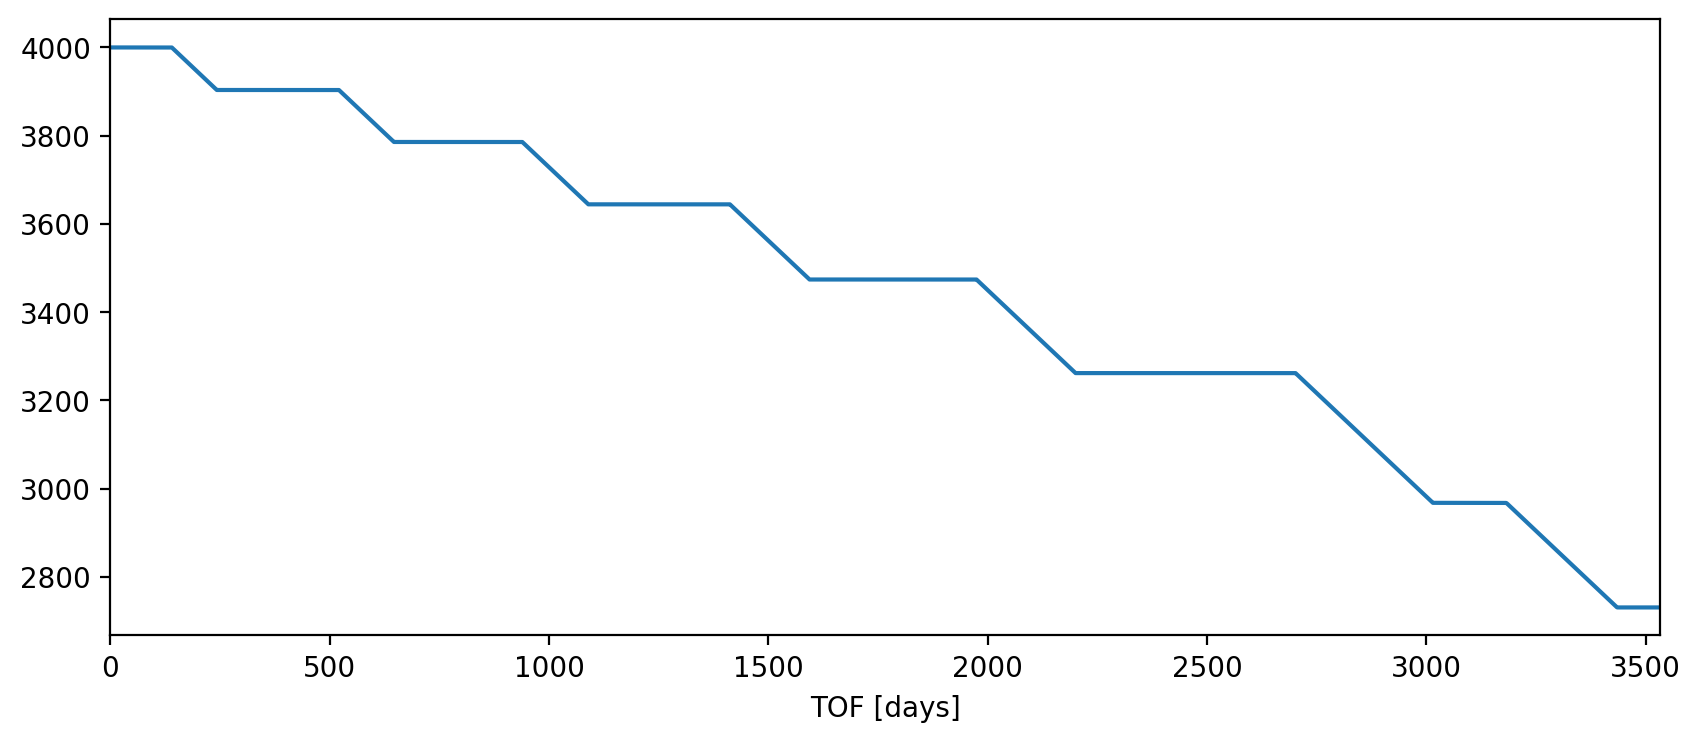

In [46]:
mass = sol.y[I.m].ravel() * MaU
plt.figure(figsize=(10, 4))
plt.plot(t, mass)
plt.xlim(t[0], t[-1])
plt.xlabel('TOF [days]')
print(f"initial mass: {mass[0]} kg")
print(f"final mass: {mass[-1]} kg")

In [64]:
from matplotlib.colors import LogNorm

<Axes: >

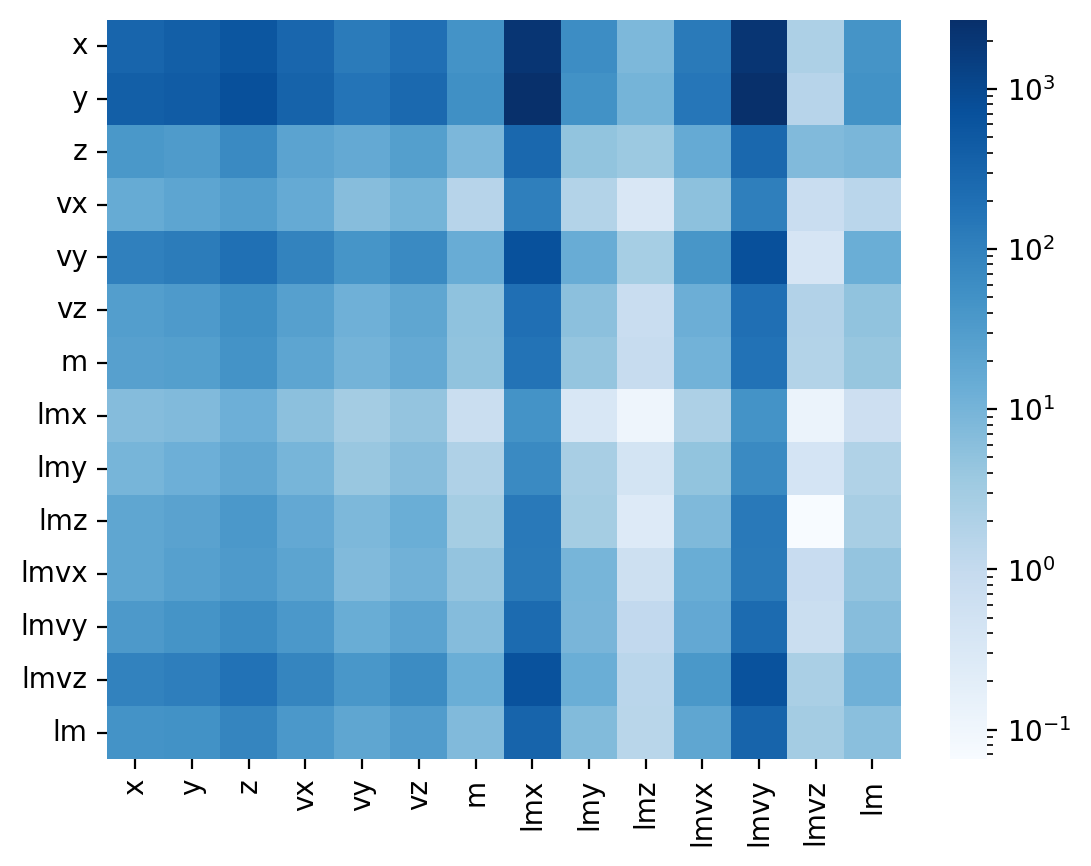

In [65]:
dXdX0 = sol_ax.dXdX0
df = pd.DataFrame(dXdX0[..., -1], columns=names, index=names)
sns.heatmap(abs(df), cmap='Blues', norm=LogNorm())